In [87]:
from astropy import units as u
from astropy.io import fits
from hiresprv.auth import login
from hiresprv.idldriver import Idldriver
from hiresprv.database import Database
from hiresprv.download import Download
from PyAstronomy import pyasl
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D
from scipy import interpolate 

import numpy as np
import pandas as pd 

In [88]:
import matplotlib.pyplot as plt 
%matplotlib inline 

# Goal: Find Strong Iodine Lines
---
- Step 1: Import Iodine Cell & Solar Spectra
- Step 2: Interoplate both the iodine cell as well as the Solar Spectra to the interpolated_wl
- Step 3: Compare both and pick out the largest lines as well as where in the solar spectra there are any lines

In [166]:
#step 1
wvlen,c = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,usecols=(1,4),unpack=True) 
solar_wl, solar_flux = wvlen[::-1], c[::-1]
iodine_wl, iodine_flux = np.genfromtxt("keck_iodine_cell.csv",delimiter=',',unpack=True) 
interpolated_wl = np.genfromtxt("interpolated_wl.csv",skip_header=1)[::-1]
interpolated_wl = interpolated_wl[:len(interpolated_wl)-5000]

In [167]:
#Step 2
solar_func = interpolate.interp1d(solar_wl, solar_flux)
solar_flux = solar_func(interpolated_wl)
iodine_func = interpolate.interp1d(iodine_wl, iodine_flux)
iodine_flux = iodine_func(interpolated_wl)

ValueError: A value in x_new is above the interpolation range.

In [91]:
pixel = [i for i in range(len(interpolated_wl))]

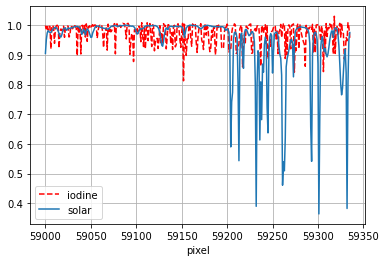

In [159]:
i = 59
begin,end  = 1000*i,1000*(i+1)
plt.plot(pixel[begin:end], iodine_flux[begin:end],'r--',label='iodine')
plt.plot(pixel[begin:end],solar_flux[begin:end],label='solar')
plt.xlabel("pixel")
plt.legend()
plt.grid()
plt.show()


In [172]:
by_eye_iodine_mask = [(0,85),(100,490),(510,575),(7400,7850),(8150,8250),(8350,8450),(8580,8650),
               (9600,9700),(10600,10800),(11650,11700),(12350,12450),(12600,12800),(13000,13300),
              (14750,14950),(15700,16000),(16500,17000),(17550,18000),(18600,18950),(19350,19400),
              (19600,20000),(21400,21600),(23200,23350),(23800,24000),(24001,24350),(24500,24850),
              (25350,25500),(26400,26700),(27200,28000),(28400,29500),(31650,32350),(32800,33150),
              (33600,33800),(34400,35050),(36900,38300),(38800,39100),(40400,40600),(41150,42400),
               (43200,43800),(45400,45750),(46000,46200),(47000,47600),(49800,50250),(50300,50800),
               (51300,51700)]
eye_iodine_mask = []
for tup in by_eye_iodine_mask:
    for i in range(tup[0],tup[1]):
        eye_iodine_mask.append(i)
l = len(interpolated_wl)
curr_pixel = 0
num_iodine_mask = []
while curr_pixel != 64336:
    if curr_pixel in eye_iodine_mask:
        num_iodine_mask.append(0)
    else:
        num_iodine_mask.append(1)
    curr_pixel +=1 
num_iodine_mask = np.array(num_iodine_mask)
        

In [173]:
num_iodine_mask.shape[0] 

64336

In [174]:
np.save('by_eye_iodine_mask.npy', num_iodine_mask)

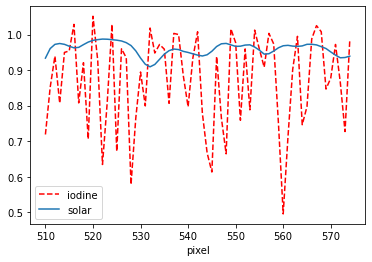

In [97]:
i = 0
begin,end  = 510,575
plt.plot(pixel[begin:end],iodine_flux[begin:end],'r--',label='iodine')
plt.plot(pixel[begin:end],solar_flux[begin:end],label='solar')

plt.xlabel("pixel")
plt.legend()
plt.show()

In [176]:

iodine_wl, iodine_flux = np.genfromtxt("keck_iodine_cell.csv",delimiter=',',unpack=True) 
interpolated_wl = np.genfromtxt("interpolated_wl.csv",skip_header=1)[::-1]
iodine_func = interpolate.interp1d(iodine_wl, iodine_flux)
iodine_flux = iodine_func(interpolated_wl)

(653609,)

59.336

# Goal: Try to Reduce Cross Corelation time as well as testing new template spectra for shifting
---
-Step 1: Import solar and other template spectra

-Step 2: Intrepolate spectra 

-Step 3: test to see correlation run time with fewer spectra and to see how the results differ 

In [65]:
#Step 1
solar_wl, solar_flux = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,usecols=(1,4),unpack=True) 
solar_wl, solar_flux = solar_wl[::-1],solar_flux[::-1]
non_solar_wl = np.genfromtxt("wavelengths.txt").flatten()
non_solar_wl.sort()
t5200_flux = np.load("flux_HD11288_T=5200K.npy")
t4702_flux = np.load("flux_HD31560_T=4702K.npy")
t6674_flux = np.load("flux_HD49933_T=6674K.npy")
t6212_flux = np.load("flux_KOI-244_T=6212K.npy")
#Intrepolated 
wl_solution = np.genfromtxt("wl_solution.csv",delimiter=',',skip_header=2)
interpolated_wl = np.genfromtxt("interpolated_wl.csv",delimiter=',')
#Testing Spectra 
test_spec = np.load("Normalized_Spectra/r20040823.125_specnorm.npy").flatten()

In [67]:
#Step 2
#Only need to interpolate the solar spectra 
solar_func = interpolate.interp1d(solar_wl, solar_flux)
#inter = np.arange(interpolated_wl[0]-5,interpolated_wl[-1] + 5,0.001)
solar_flux_i = solar_func(wl_solution)

In [68]:
i = 1
begin, end = 4021*i, 4021*(i+1)
temp_flux_indeces = np.logical_and((wl_solution[begin]-5) <= non_solar_wl,
                                   (wl_solution[end]+5)>= non_solar_wl)
temp_flux = t5200_flux[temp_flux_indeces]
temp_wl = non_solar_wl[temp_flux_indeces]

 cc = 2968.7787664973002
              rv = -32.80000000000017
 cc = 2906.370550136314
              rv = -31.733333333333505
 cc = 3036.73111451951
              rv = -48.80000000000011
 cc = 3006.6788362200077
              rv = -47.20000000000012
6.1445653438568115
 cc = 2823.718267982155
            rv = 79.86666666667463


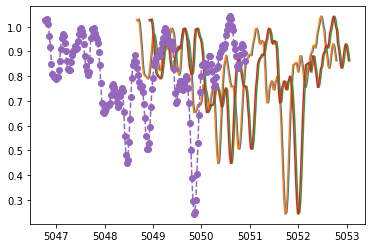

In [87]:
#Step 3 
#On all the other templates
indeces = np.logical_and((wl_solution[begin]-5) <= non_solar_wl,
                         (wl_solution[end]+5)>= non_solar_wl)
looking_start,looking_end = 3200, 3400

temp_wl = non_solar_wl[indeces]
import time 
begin_time = time.time()
for temp_flux_iiii in [t5200_flux,t4702_flux,t6674_flux,t6212_flux]:
    #temp_flux = temp_flux[indeces]
    rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                               non_solar_wl, temp_flux_iiii, -80, 80, 80/300., skipedge=100)

    print(f''' cc = {cc[np.argmax(cc)]}
              rv = {rv[np.argmax(cc)]}''')
    z = rv[np.argmax(cc)]/299_792.458  #UNITS: None 
    computeShiftedWavelength = lambda wl: wl/ (1 + z)  #UNITS: Angstroms
    #There has to be a better way to convert to a numpy array
    shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
    plt.plot(shifted_wl[looking_start:looking_end],test_spec[looking_start:looking_end]) #Needs an absorb line on the left of 5050 Angstorms
    #plt.show()
end_time = time.time() - begin_time
print(end_time)
    

#Solar 
solar_indeces = np.logical_and((wl_solution[begin]-80) <= solar_wl,
                               (wl_solution[end]+80)   >= solar_wl)

rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                               solar_wl[solar_indeces], solar_flux[solar_indeces],
                           -80, 80, 80/600., skipedge=100)
print(f''' cc = {cc[np.argmax(cc)]}
            rv = {rv[np.argmax(cc)]}''')
z = rv[np.argmax(cc)]/299_792.458  #UNITS: None 
computeShiftedWavelength = lambda wl: wl/ (1 + z)  #UNITS: Angstroms
#There has to be a better way to convert to a numpy array
shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
plt.plot(shifted_wl[looking_start:looking_end],test_spec[looking_start:looking_end],'o--') #Needs an absorb line on the left of 5050 Angstorms
plt.show()

 cc = 2968.7787664973002
              rv = -32.80000000000017
 cc = 2906.3359488219303
              rv = -31.200000000000173
 cc = 3036.73111451951
              rv = -48.80000000000011
 cc = 3006.6788362200077
              rv = -47.20000000000012
 cc = 2819.03956295805
            rv = 79.19999999999942


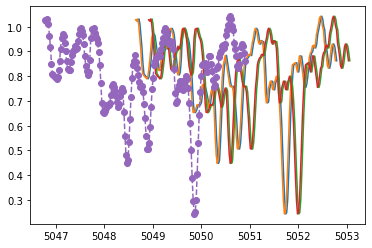

In [85]:
#Trying a different normalized spectra. One that is not a solar type star
test_spec = np.load("Normalized_Spectra/r20050130.146_specnorm.npy").flatten()
indeces = np.logical_and((wl_solution[begin]-5) <= non_solar_wl,
                         (wl_solution[end]+5)>= non_solar_wl)
looking_start,looking_end = 3200, 3400

temp_wl = non_solar_wl[indeces]
for temp_flux_iiii in [t5200_flux,t4702_flux,t6674_flux,t6212_flux]:
    #temp_flux = temp_flux[indeces]
    rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                               non_solar_wl, temp_flux_iiii, -80, 80, 80/200., skipedge=100)

    print(f''' cc = {cc[np.argmax(cc)]}
              rv = {rv[np.argmax(cc)]}''')
    z = rv[np.argmax(cc)]/299_792.458  #UNITS: None 
    computeShiftedWavelength = lambda wl: wl/ (1 + z)  #UNITS: Angstroms
    #There has to be a better way to convert to a numpy array
    shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
    plt.plot(shifted_wl[looking_start:looking_end],test_spec[looking_start:looking_end]) #Needs an absorb line on the left of 5050 Angstorms
    #plt.show()
    
    

#Solar 
solar_indeces = np.logical_and((wl_solution[begin]-80) <= solar_wl,
                               (wl_solution[end]+80)   >= solar_wl)

rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                               solar_wl[solar_indeces], solar_flux[solar_indeces],
                           -80, 80, 80/100., skipedge=100)
print(f''' cc = {cc[np.argmax(cc)]}
            rv = {rv[np.argmax(cc)]}''')
z = rv[np.argmax(cc)]/299_792.458  #UNITS: None 
computeShiftedWavelength = lambda wl: wl/ (1 + z)  #UNITS: Angstroms
#There has to be a better way to convert to a numpy array
shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
plt.plot(shifted_wl[looking_start:looking_end],test_spec[looking_start:looking_end],'o--') #Needs an absorb line on the left of 5050 Angstorms
plt.show()

In [89]:
#If the RV is *close* to 80 km/s then try the other spectra
#Need to first find a spectra that demonstrates this 
#To do testing on this spectra
import os 
normalized_directory = r"Normalized_Spectra"
directories = os.listdir(normalized_directory)

solar_indeces = np.logical_and((wl_solution[begin]-80) <= solar_wl,
                               (wl_solution[end]+80)   >= solar_wl)
for file in directories:
    if file[-10:-1]  == 'ecnorm.np': #specnorm.npy
        test_spec = np.load(f"Normalized_Spectra/{file}").flatten()
        rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                                       solar_wl[solar_indeces], solar_flux[solar_indeces],
                                   -80, 80, 80/300., skipedge=100)
        if not (-75 < rv[np.argmax(cc)] < 75) and not file in 'r20050130.146_specnorm.npy':
            print(file)
            break 
        print("next")
        

next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
next
r20060312.125_specnorm.npy


 cc = 3043.6802910282595
              rv = -33.999999999999346
 cc = 2979.676564767539
              rv = -33.199999999999335
 cc = 3114.437207143068
              rv = -48.79999999999956
 cc = 3083.4149247492073
              rv = -65.19999999999979
 cc = 2897.865432008818
            rv = 79.19999999999942


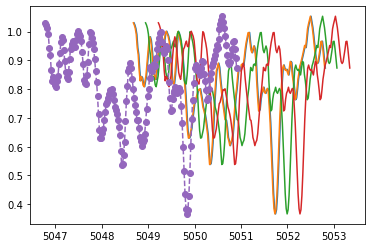

In [90]:
#r20050130.146_specnorm.npy
#Can Delete 
test_spec = np.load("Normalized_Spectra/r20060312.125_specnorm.npy").flatten()
indeces = np.logical_and((wl_solution[begin]-5) <= non_solar_wl,
                         (wl_solution[end]+5)>= non_solar_wl)
looking_start,looking_end = 3200, 3400

temp_wl = non_solar_wl[indeces]
for temp_flux_iiii in [t5200_flux,t4702_flux,t6674_flux,t6212_flux]:
    #temp_flux = temp_flux[indeces]
    rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                               non_solar_wl, temp_flux_iiii, -80, 80, 80/200., skipedge=100)

    print(f''' cc = {cc[np.argmax(cc)]}
              rv = {rv[np.argmax(cc)]}''')
    z = rv[np.argmax(cc)]/299_792.458  #UNITS: None 
    computeShiftedWavelength = lambda wl: wl/ (1 + z)  #UNITS: Angstroms
    #There has to be a better way to convert to a numpy array
    shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
    plt.plot(shifted_wl[looking_start:looking_end],test_spec[looking_start:looking_end]) #Needs an absorb line on the left of 5050 Angstorms
    #plt.show()
    
    

#Solar 
solar_indeces = np.logical_and((wl_solution[begin]-80) <= solar_wl,
                               (wl_solution[end]+80)   >= solar_wl)

rv, cc = pyasl.crosscorrRV(wl_solution[begin:end], test_spec[begin:end],
                               solar_wl[solar_indeces], solar_flux[solar_indeces],
                           -80, 80, 80/100., skipedge=100)
print(f''' cc = {cc[np.argmax(cc)]}
            rv = {rv[np.argmax(cc)]}''')
z = rv[np.argmax(cc)]/299_792.458  #UNITS: None 
computeShiftedWavelength = lambda wl: wl/ (1 + z)  #UNITS: Angstroms
#There has to be a better way to convert to a numpy array
shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
plt.plot(shifted_wl[looking_start:looking_end],test_spec[looking_start:looking_end],'o--') #Needs an absorb line on the left of 5050 Angstorms
plt.show()

 cc = 2968.797681016945
              rv = -32.66666666666431
 cc = 2906.3788078732327
              rv = -31.066666666664233
 cc = 3036.73111451951
              rv = -48.79999999999845
 cc = 3006.6788362200077
              rv = -47.19999999999837


In [50]:
wl_solution[begin]

5047.727430585564

In [62]:
#Testing reducing run time 
# import time 
# begin = time.time()
# rv, cc = pyasl.crosscorrRV(interpolated_wl, test_spec,
#                            solar_wl,solar_flux, -80, 80, 80/600., skipedge=20)
# end = time.time() - begin 
# print(rv[np.argmax(rv)])
# print(f"Took {end/60} minutes")
# begin = time.time()
# for spec in [t5200_flux,t4702_flux,t6674_flux,t6212_flux]:
#     begin = time.time()
#     rv2, cc2 = pyasl.crosscorrRV(interpolated_wl, test_spec,
#                                non_solar_wl,spec, -80, 80, 80/600., skipedge=20)
#     end = time.time() - begin 
#     print(rv2[np.argmax(rv2)])
#     print(f"Took {end/60} minutes")

162635

In [64]:
rv2[np.argmax(rv2)]

79.86666666667463

In [69]:
non_solar_wl.sort()

In [66]:
t4702_flux

array([0.73940029, 0.81479946, 0.87724628, ..., 0.78969717, 0.8530967 ,
       0.89372748])

In [70]:
non_solar_wl[np.argmin(non_solar_wl)]

4978.766773203589

In [72]:
interpolated_wl[np.argmin(interpolated_wl)]

4978.766773203589

# Goal: Figure what stars have < 100 S/N 
---
Step 1: Use os to find all the files in the SpectraOutput folder 

Step 2: Open the fits files using fits modules, open the hdu header, then look for the S/N 

Step 3: Scale to check all in the files, there is some method that allows you to do look at specific parameters 

Step 4: Check also for those flagged as "bad" 

Step 5: If there are a copuious amount of either one, figure out a replace strat. Probably to just use another Iodine induced Spectra

In [1]:
import os 
from astropy.io import fits

In [2]:
#Step 1: 
spectra_directory = r"SpectraOutput"
directory = os.listdir(spectra_directory)

i = 0
j = 0
for file in directory:
    hdul = fits.open(spectra_directory + "/" + file)
    if i == 7:
        print(file)
        print(hdul[0].header)
    i += 1
    hdul.close()
    break 
#     try:
#         hdul = fits.open(spectra_directory + "/" + file)
        
#         try:
#             val = hdul[0].header["SIG2NOIS"]
#             print(val)
#             j += 1
#         except KeyError:
#             #print("")
#             print('i =',i)
#             pass
#         hdul.close()
#     except OSError: 
#         pass
    

In [3]:
hdul = fits.open(spectra_directory + "/" + directory[7])
    

In [4]:
hdul[0].header

SIMPLE  =                    T / Written by IDL:  Sat Feb 22 02:59:46 2020      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4021 /Number of positions along axis 1                
NAXIS2  =                   16 /Number of positions along axis 2                
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                    0 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2004-10-24T12:33:25' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
COMMENT BEGIN observation-specific keywords written by write_image              
COMMENT BEGIN keywords that 

In [5]:
import json
import os
from hiresprv.download import Download

data = Download('prv.cookies', './', debug=True)

listing = data.directory_listing()
prtstring = json.dumps(listing, indent=4, sort_keys=True)[:2000]
prtstring += "\n... output truncated ..."

print(prtstring)

{
    "database": "prvState.db",
    "deblazed": [
        "deblazed/r20050226.27.fits",
        "deblazed/r20061015.124.fits",
        "deblazed/r20120703.118.fits",
        "deblazed/r20090512.89.fits",
        "deblazed/r20130629.18.fits",
        "deblazed/r20170711.1.fits",
        "deblazed/r20100403.107.fits",
        "deblazed/r20130827.111.fits",
        "deblazed/r20110921.160.fits",
        "deblazed/r20090806.122.fits",
        "deblazed/r20121228.67.fits",
        "deblazed/r20160125.4.fits",
        "deblazed/r20090205.113.fits",
        "deblazed/r20041023.206.fits",
        "deblazed/r20100624.191.fits",
        "deblazed/r20130701.246.fits",
        "deblazed/r20081206.132.fits",
        "deblazed/r20090702.71.fits",
        "deblazed/r20050226.249.fits",
        "deblazed/r20050418.150.fits",
        "deblazed/r20151127.63.fits",
        "deblazed/r20090831.79.fits",
        "deblazed/r20161125.115.fits",
        "deblazed/r20180801.58.fits",
        "deblazed/r200601

### Goal: Convert all csv files to npy files (to save time and space) 
---- 
Step 1: Copy the relative paths to all the files

Step 2: Check to make sure strings and values can be in the same array 

Step 3: Convert all to npy files now 

Step 4: Test main.ipynb as well as HIRESTheCannon.ipynb

In [52]:
import numpy as np
import pandas as pd

In [ ]:
#Step 1
fluxes_for_HIRES.csv #Done 
HIRES_Filename_rv.csv   #Not going to change
interpolated_wl.csv #Not going to change
ivar_for_HIRES.csv #Done
keck_iodine_cell.csv #Done
wl_solution.csv #Not going to change
Atlases/solarAtlas.txt #Done 

In [41]:
#Step 2 
hires = pd.read_csv("HIRES_Filename_rv.csv")

In [42]:
hires

,HIRESName,FILENAME,RV
0,HD33822,r20071124.121,-16286.794922
1,HD72905,r20131019.184,-10597.124723
2,HD109409,r20060416.170,269.224258
3,HD26965,r20101212.153,13.500941
4,HD38858,r20071219.141,-15.180925
...,...,...,...
733,HD179306,r20100719.57,-16.683694
734,HD1666,r20100719.83,-254.358750
735,HD2564,r20100723.56,42.717925
736,HD231701,r20050821.171,50.188435


In [24]:
np.save("fluxes_for_HIRES",hires_fluxes.to_numpy())
np.save("ivar_for_HIRES",hires_ivars.to_numpy())

In [45]:
t = np.genfromtxt("keck_iodine_cell.csv",delimiter=',')


In [50]:
np.save("../Constants/keck_iodine_cell",t)

In [51]:
np.load("../Constants/keck_iodine_cell.npy")

array([[4.9500005e+03, 9.8871017e-01],
       [4.9500039e+03, 9.7771833e-01],
       [4.9500074e+03, 9.7180265e-01],
       ...,
       [6.3999873e+03, 9.9763451e-01],
       [6.3999930e+03, 9.9861091e-01],
       [6.3999988e+03, 9.9849177e-01]])

In [32]:
np.save("../spocData/ivar_contdiv_polynomial_all",ivar_contdiv_polynomial_all)

In [54]:
solar = np.load('../Constants/solarAtlas.npy')
solar[:,1][::-1]

In [56]:
solar.shape

(1286393, 6)

In [84]:
solar[:,1][::-1]

array([4442.9976, 4442.9995, 4443.0015, ..., 9257.5439, 9257.5498,
       9257.5557])

In [82]:
solar[0]

array([1.07990039e+04, 9.25755570e+03, 9.83130000e-01, 9.92180000e-01,
       9.75440000e-01, 1.00000000e+00])

In [80]:
 wvlen,c = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,usecols=(1,4),unpack=True) 
        
wvlen, c = wvlen[::-1], c[::-1]

In [86]:
(wvlen == solar[:,1][::-1]).all()

True